# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science 
## GROUP #17 Term Project - Bounding Boxes

**Harvard University**<br/>
**Summer 2018**<br/>
**Prepared By**: Group #17 Zachary Sullivan, Yuil Ahn, Samuel Akwei-Sekyere

**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

from PIL import Image
import pandas as pd
import cv2
import os
import numpy as np
from bs4 import BeautifulSoup
from sklearn.utils import shuffle
import seaborn as sns

In [2]:
# Return a beautiful soup object from the provided file
def obtain_annotations (filename):    
    if os.path.exists(filename):
        with open(filename) as fp:
            return BeautifulSoup(fp, "lxml")

# Return the bounding box x,y dimensions for the given image
def obtain_boundBox_loc (soup):
    # Use beautiful soup to parse the label file, ensure our output variables are integer dtypes
    xmin = int(soup.find("xmin").text)
    xmax = int(soup.find("xmax").text)
    ymin = int(soup.find("ymin").text)
    ymax = int(soup.find("ymax").text)
    
    return (xmin, xmax, ymin, ymax)

# Given the dog label, return a enumerated value that corresponds with the dogs breed (0 = bull, 1 = gershep)
def obtain_dogclass (soup):
    breed = soup.find("name").text
    if (breed == 'Boston_bull'):
        return 0
    elif (breed == 'German_shepherd'):
        return 1
    else:
        return None

In [3]:
# Crop the provided image based on the provided bounding dimensions 
def generate_boundBox (img, xmin, xmax, ymin, ymax):
    crop_img = img[ymin:ymax, xmin:xmax]
    return crop_img

In [4]:
#Generate a feature matrix on the cropped image

# Resize our image to a uniform size and flatten it
# Return a new list containing the raw pixel values
def image_to_feature_vector(image, size):
    return cv2.resize(image, (size, size)).flatten()

In [5]:
def load_images_from_folder(imageFolder, labelFolder, size):

    pixValues = []
    classes = []
    for filename in os.listdir(imageFolder):
        
        img = cv2.imread(os.path.join(imageFolder, filename))
        
        if img is not None:
            
            bsObj = obtain_annotations(labelFolder + filename[:-4])
            
            xmin, xmax, ymin, ymax = obtain_boundBox_loc(bsObj)
            
            crop_img = generate_boundBox(img, xmin, xmax, ymin, ymax)
            
            pixValues.append(image_to_feature_vector(crop_img, size))
            
            classes.append(obtain_dogclass(bsObj))

    return np.array(pixValues), np.array(classes)

In [10]:
# Appends list values to selected columns given a provided dataframe 
# Returns the update dataframe
def DfAppend_Vals(dataFrame, matrix, columns):
    for vector in matrix:
        dataFrame = dataFrame.append(pd.Series(vector, index = columns), ignore_index=True)

    return dataFrame

In [44]:
def Gen_PCA_T2_Plot(X_train_pca, y_train):
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=["pca1", "pca2"])
    X_train_pca_df["Class"] = y_train.values
    sns.lmplot(x = "pca1", y = "pca2", hue="Class", data = X_train_pca_df, fit_reg = False, legend = False, palette = 'bwr')
    plt.title("Top Two Principal Components")
    plt.legend(('Boston Bull', 'German Shepherd'))

In [45]:
def Obtain_top2_PCA_Components(X_train):
    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    
    # Plot the top 2 pca components
    Gen_PCA_T2_Plot(X_train_pca, out_df["Class"])
    
    return np.sum(pca.explained_variance_ratio_)

In [41]:
accuracy_score_size_f, accuracy_score_size_t, accuracy_score_size_knn, accuracy_score_size_ada, accuracy_score_size_ens =[], [], [], [], []
size = [25,50,75]

In [15]:
for j in range(len(size)):
    imgPixMat, imgClassMat = load_images_from_folder('./Dog Images/n02096585-Boston_bull', './Annotation/n02096585-Boston_bull/', size[j])

    columnNames = []

    for i in range(0, (np.power(size[j],2)*3)):
        columnNames.append(('Pixel '+str(i)))

    data_df = pd.DataFrame(columns=columnNames)
    data_df = DfAppend_Vals(data_df, imgPixMat, columnNames)
    class_df = pd.DataFrame(columns=['Class'])

    class_df = DfAppend_Vals(class_df, imgClassMat, ['Class'])
    imgPixMat, imgClassMat = load_images_from_folder('./Dog Images/n02106662-German_shepherd', './Annotation/n02106662-German_shepherd/', size[j])
    data_df = DfAppend_Vals(data_df, imgPixMat, columnNames)
    class_df = DfAppend_Vals(class_df, imgClassMat, ['Class'])


    out_df = pd.concat([data_df, class_df], axis=1)
    
    out_df = shuffle(out_df)

The first two principal components explain 0.218 of the variance in model 0
The first two principal components explain 0.218 of the variance in model 1
The first two principal components explain 0.218 of the variance in model 2


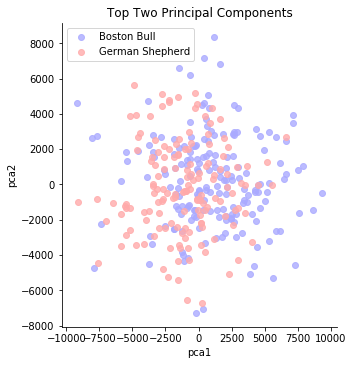

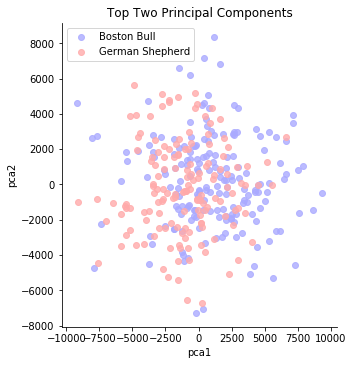

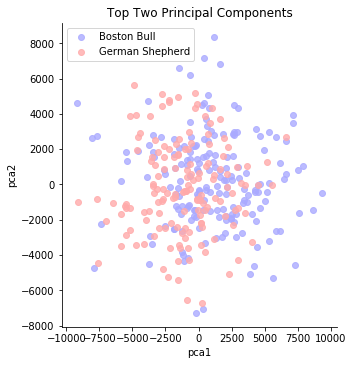

In [46]:
for j in range(len(size)):   
    print("The first two principal components explain %0.3f" % Obtain_top2_PCA_Components(out_df.drop('Class', axis=1)), "of the variance in model", j)

In [16]:
for j in range(len(size)):    
    pca=PCA()
    X = pca.fit_transform(out_df.drop('Class', axis=1))
    a, num = 0, 0
    for i in range(X.shape[1]):
        a+=pca.explained_variance_ratio_[i]
        num+=1
        if a>0.9:
            break
    pca=PCA(num)
    pca.fit_transform(X)

    x_train, x_test, y_train, y_test = train_test_split(X, out_df.iloc[:,-1], test_size=0.3)

    y_train=y_train.astype('int')
    y_test=y_test.astype('int')

In [102]:
crossVal_scs = []

for j in range(len(size)): 
    
    C = [1, 3, 5, 7, 10, 15]
    tree_acc = []
    
    
    for i in range(len(C)):
        model = DecisionTreeClassifier(max_depth=C[i])
        model.fit(x_train, y_train)
        tree_acc.append(accuracy_score(y_test, model.predict(x_test)))
        
        scores = cross_val_score(estimator=model, X=x_train, y=y_train, cv=5)
        crossVal_scs.append(scores.mean())
                
    C_star = C[np.argmax(tree_acc)]
    model = DecisionTreeClassifier(max_depth=C_star)
    model.fit(x_train, y_train)
    
    y_pred_treet = model.predict_proba(x_train)[:,1]
    y_pred_tree = model.predict(x_test)
    y_pred_treep = model.predict_proba(x_test)[:,1]
    
    accuracy_score_size_t.append(accuracy_score(y_pred_tree, y_test))
    
    y_p_t = model.predict(x_train)

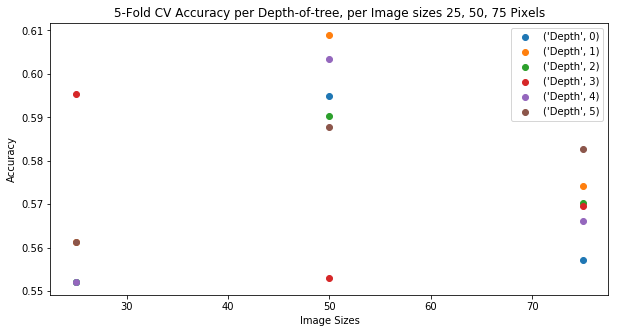

In [109]:
crossVal_scs = np.reshape(crossVal_scs, (6, 3))

plt.figure(figsize=(10,5))

for idx, scores in enumerate(crossVal_scs):  
    plt.plot([25, 50, 75], scores, linestyle='None', marker='o', label=("Depth", idx))


plt.title("5-Fold CV Accuracy per Depth-of-tree, per Image sizes 25, 50, 75 Pixels")
plt.xlabel("Image Sizes")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('5-Fold_CV_Acc_Depth_tree.png')


In [110]:
for j in range(len(size)): 
    rf = RandomForestClassifier()
    param_grid = {'max_depth':[1,3,5,7,10,15], 'n_estimators':[5,10,15,20,25,30,35],'criterion':['gini',
                'entropy']}
    gs = GridSearchCV(cv=5, param_grid=param_grid, estimator=rf)
    gs.fit(x_train, y_train)
    cc = gs.best_params_
    rf = RandomForestClassifier(max_depth=cc['max_depth'], n_estimators=cc['n_estimators'],
                              criterion=cc['criterion'])
    rf.fit(x_train, y_train)
    y_p_r = rf.predict_proba(x_train)[:,1]
    y_pred_for = rf.predict(x_test)
    y_pred_forr = rf.predict_proba(x_train)[:,1]

    y_pred_forp = rf.predict_proba(x_test)[:,1]

    accuracy_score_size_f.append(accuracy_score(y_pred_for, y_test))

In [111]:
for j in range(len(size)): 
    nei = knn(2)
    nei.fit(X=x_train, y=y_train)
    y_pred_knn=nei.predict(x_test)
    accuracy_score_size_knn.append(accuracy_score(y_pred_knn, y_test))

In [ ]:
for j in range(len(size)): 
    ada = AdaBoostClassifier(algorithm='SAMME')
    param_grid = {'n_estimators':[10,20,30,40,50,60], 'learning_rate':[0.001, 0.01, 0.1, 1.]}
    gs = GridSearchCV(cv=5, param_grid=param_grid, estimator=ada)
    gs.fit(x_train, y_train)
    cc = gs.best_params_
    ada = AdaBoostClassifier(n_estimators=cc['n_estimators'], learning_rate=cc['learning_rate'])
    ada.fit(x_train, y_train)
    y_p_a = ada.predict(x_train)
    y_pred_adaa = ada.predict_proba(x_train)[:,1]
    y_pred_ada = ada.predict(x_test)
    
    y_pred_adap = ada.predict_proba(x_test)[:,1]
    accuracy_score_size_ada.append(accuracy_score(y_pred_ada, y_test))

In [ ]:
for j in range(len(size)): 
    train_ = pd.DataFrame(y_pred_treet)
    b_ = pd.DataFrame(y_pred_forr)
    c_ = pd.DataFrame(y_pred_adaa)
    train_ = train_.join(b_, how='left', lsuffix='_')
    train_ = train_.join(c_, how='left', lsuffix='_')
    test = pd.DataFrame(y_pred_treep)
    b = pd.DataFrame(y_pred_forp)
    c = pd.DataFrame(y_pred_adap)
    test = test.join(b,how='left', lsuffix='_')
    test = test.join(c, how='left', lsuffix='_')    
    rtcv = LogisticRegressionCV(refit=True)
    rtcv.fit(train_, y_train)
    accuracy_score_size_ens.append(accuracy_score(y_test, rtcv.predict(test)))

In [13]:
accuracy={}
accuracy.update({'ada':accuracy_score_size_ada})    
accuracy.update({'knn':accuracy_score_size_knn})    
accuracy.update({'tree':accuracy_score_size_t})    
accuracy.update({'forest':accuracy_score_size_f})    
accuracy.update({'ensemble':accuracy_score_size_ens})

print("Accuracy Scores for the corresponding models:", accuracy)

Accuracy Scores for the corresponding models: {'ada': [0.72, 0.59, 0.72], 'knn': [0.57, 0.6, 0.66], 'tree': [0.55, 0.67, 0.63], 'forest': [0.66, 0.61, 0.64], 'ensemble': [0.55, 0.64, 0.6]}


In [14]:
f=open('results', 'w')
f.write(repr(accuracy))
f.close()